In [13]:
%matplotlib inline
import numpy as np
import theano
import theano.tensor as TT
from theano import shared, function
import pandas as pd

In [2]:
# -- Set up our simulation to run with a particular precision

floatX = theano.config.floatX  # either 'float32' or 'float64'

def sharedX(obj, name):
    """Create shared variable for ndarray'd obj with dtype=floatX
    """
    return shared(np.asarray(obj, dtype=floatX))

In [3]:
# -- Assign simulation parameters
#    Written in this way these will be *compiled in* to the
#    tick() function below, as Theano *contants*.

N = 100          # -- number of neurons
D = 3            # -- state vector dimensionality

t_rc = 0.01      # -- some capacitance constant
t_ref = 0.001    # -- refractory period (1/max spike rate?)
dt = 0.001       # -- simulation time-step
pstc = 0.05      # -- post-synaptic time constant (low-pass filter on spikes in state update)

encoders = np.random.randn(N, D).astype(floatX)
decoders = np.random.randn(N, D).astype(floatX)

In [6]:
# -- Define the recurrence of the LIF model

# -- Place persistent quantities into shared variables 
state = sharedX(np.zeros(D), 'state')
voltage = sharedX(np.zeros(N), 'voltage')
refractory_time = sharedX(np.zeros(N), 'refractory_time')
J_bias = sharedX(np.random.randn(N), 'J_bias')
Jm_prev = sharedX(np.zeros(N), 'Jm_prev')

state_w_bias = TT.set_subtensor(state[0], 0.5)

Jm = TT.dot(encoders, state) + J_bias

# -- Euler's method
dV = dt / t_rc * (Jm_prev - voltage)
new_v = TT.maximum(voltage + dV, 0)

post_ref = 1.0 - (refractory_time - dt) / dt  

# -- Do accurate timing for when the refractory period ends   (probably not needed for FPGA neuron model)
new_v *= TT.clip(post_ref, 0, 1)

V_threshold = 1

spiked = TT.switch(new_v > V_threshold, 1.0, 0.0)

# -- Refractory stuff
overshoot = (new_v - V_threshold) / dV
spiketime = dt * (1.0 - overshoot)
new_refractory_time = TT.switch(spiked,
            spiketime + t_ref,
            refractory_time - dt)
        
# -- low-pass filter on state
decay = float(np.exp(-dt / pstc))
new_state = (state * decay
             + (1 - decay) * TT.dot(spiked, decoders) / dt)

In [7]:
# -- Compile a function to evaluate one time-step of the model

tick = function([], [],
                updates={
                         voltage: new_v * (1 - spiked),
                         state: new_state,
                         refractory_time: new_refractory_time,
                         Jm_prev: Jm})

/Users/dikien/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: UserWarning: The parameter 'updates' of theano.function() expects an OrderedDict, got <type 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (theano.compat.python2x.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.


In [8]:
# -- Step through time, retrieving the voltage value.
voltages = []
for i in range(1000):
    tick()
    voltages.append(voltage.get_value())

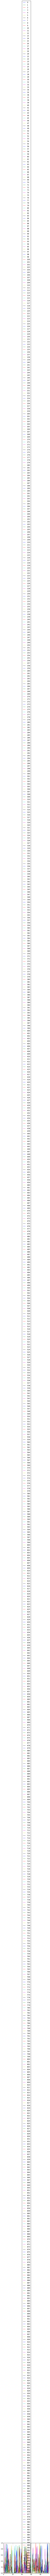

In [14]:
pd.DataFrame(np.asarray(voltages).T).plot()